### GridWorld

We will first build the gridworld in which our RL agents will have to live and learn.

In [18]:
# import the necessary packages
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
# from copy import deepcopy


# We now create a class that will contain the task. 
# This class will be called to generate the trials that we will use to train the agent.
class GridWorld():
    """
     GridWorld task.

    Args:
        size: int, size of the grid
        start: tuple, starting position of the agent
        goal: tuple, goal position of the agent
        obstacles: list of tuples, positions of the obstacles
    """
    def __init__(self, size=5, start=(0, 0), goal=(4, 4), obstacles=None,
                 max_steps_per_trial=50):
        # define the task parameters
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles or []
        self.max_steps_per_trial = max_steps_per_trial
        # observation space
        self.observation_space = spaces.Box(-np.inf, np.inf,
                                            shape=(9,), dtype=np.float32)
        # action space
        self.action_space = spaces.Discrete(5)
        # rewards for reaching the goal (correct), not reaching the goal (fail) and hitting an obstacle
        self.rewards = {'correct': 50, 'obstacle': -2, 'fail': -1}
        self.position = self.start
        # step within the trial
        self.t = 0
        self.trial = 0

    def new_trial(self, **kwargs):
        """
        new_trial() is called when a trial ends to generate the next trial.
        kwargs could be used to modify the goal or start positions.    
        """
        self.t = 0
        self.trial += 1

    def step(self, action):
        """
        step receives an action and returns:
            a new observation, the position of the agent
            reward associated with the action, reward
            a dictionary with extra information:
                boolean indicating the end of the trial, info['new_trial']
        """
        self.t += 1
        new_trial = False
        candidate = self.position
        # process action
        if action == 1:  # Move up
            candidate = (max(self.position[0] - 1, 0), self.position[1])
        elif action == 2:  # Move right
            candidate = (self.position[0], min(self.position[1] + 1, self.size - 1))
        elif action == 3:  # Move down
            candidate = (min(self.position[0] + 1, self.size - 1), self.position[1])
        elif action == 4:  # Move left
            candidate = (self.position[0], max(self.position[1] - 1, 0))
        
        # Updtate reward and position
        if candidate == self.goal:
            reward = self.rewards['correct']
            self.position = self.start
            new_trial = True
            self.new_trial()
        elif candidate in self.obstacles:
            reward = self.rewards['obstacle']
        else:
            self.position = candidate
            reward = self.rewards['fail']

        # check time limit
        if self.t > self.max_steps_per_trial:
            self.position = self.start
            new_trial = True
            self.new_trial()

        return self.position, reward, {'new_trial': new_trial}

    def render(self, ax=None):
        """
        Display position of the agent, obstacles and goal in a grid.
        """
        grid = np.zeros((self.size, self.size))
        grid[self.position] = 1  # agent's position marked with 1
        grid[self.goal] = 2  # goal position marked with 0.5
        for obstacle in self.obstacles:
            grid[obstacle] = -1
        # pad grid with -1
        grid = np.pad(grid, pad_width=1, mode='constant', constant_values=-1)
        if ax is None:
            _, ax = plt.subplots()
        ax.imshow(grid, vmin=-1, vmax=2, cmap='hot')

##### Plot an example environment

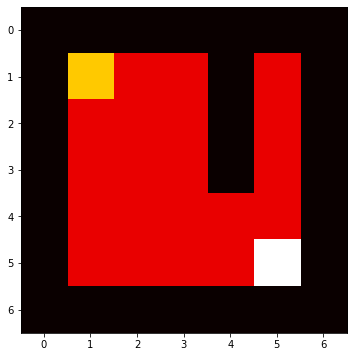

In [19]:
grid_size = 5
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size-2) for x in range(grid_size-2)]
max_steps_per_trial = 20
env = GridWorld(size=grid_size, start=start, goal=goal, obstacles=obstacles, max_steps_per_trial=max_steps_per_trial)
f, ax = plt.subplots(figsize=(6, 6))
env.render(ax=ax)

### Auxiliary functions

In [20]:
def plot_reward_per_episode(reward_per_episode, ax=None):   
    # Plot rewards
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    ax.plot(reward_per_episode,'b')
    ax.title("Reward per episode")
    ax.xlabel("Episode")
    ax.ylabel("Total Reward")
    ax.show()

def plot_q_table(agent, action_space):
    # plot q_table
    f, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
    ax = ax.flatten()
    # actions
    titles = ['Stay', 'Up', 'Right', 'Down', 'Left']
    for i_a, a in enumerate(ax):
        if i_a < len(action_space):
            im = a.imshow(agent.get_q_table()[:, :, i_a], cmap='hot')
            plt.colorbar(im, ax=a)
            a.set_title(titles[i_a])
    plt.show()

### Experience function

In [21]:
def train_agent(agent, grid_size=5, start=(0, 0), goal=(4, 4), obstacles=[(x, 3) for x in range(3)],
                max_num_tr=100, render_flag=False, render_trial=20, max_steps_per_trial=50):
    """
    Create gridWorld and agent, and train agent for a number of trials.

    Args:
        agent: agent to train
        grid_size: int, size of the grid
        start: tuple, starting position of the agent
        goal: tuple, goal position for the agent
        obstacles: list of tuples, positions of the obstacles
        max_num_tr: int, maximum number of trials
        render_flag: bool, whether to display the environment
        render_trial: int, trial to display
        max_steps_per_trial: int, maximum number of steps per trial
    """
    # Create grid world
    env = GridWorld(size=grid_size, start=start, goal=goal, obstacles=obstacles, max_steps_per_trial=max_steps_per_trial)

    # INSTRUCTION 1: first action of the agent. Which parameters do you need to pass to the agent?
    action = agent.get_action(state=start)
    state, _, _ = env.step(action)
    reward_per_episode = []
    total_reward = 0
    while env.trial < max_num_tr:
        # INSTRUCTION 2: get the next action from the agent.
        action = agent.get_action(state=state)
        next_state, reward, info = env.step(action)
        # INSTRUCTION 3: learn from the experience. Which parameters do you need to pass to the agent?
        agent.learn(state=state, action=action, reward=reward, next_state=next_state)
        state = next_state
        if render_flag and env.trial == render_trial:
            print(f"Trial: {env.trial + 1}, Step: {env.t + 1}, State: {state}, Action: {action}, Next State: {next_state},\
                    Reward: {reward}, Total Reward: {total_reward}, New trial: {info['new_trial']}")
        total_reward += reward
        if info['new_trial']: # check if the trial has ended
            reward_per_episode.append(total_reward)
            total_reward = 0
        if render_flag and env.trial == render_trial:
            _, ax = plt.subplots(figsize=(2, 2))
            env.render(ax=ax)
            plt.show()
    return reward_per_episode

### Random Agent

In [22]:
class Random:
    def __init__(self, action_space):
        self.action_space = action_space
    # INSTRUCTION 4: return the agent's action.
    # (hint: you might need to add some dummy input parameters (i.e. not used) so the function works well with the train_agent function)
    def get_action(self, state):
        return np.random.choice(self.action_space)
    # INSTRUCTION 5: learn from experience (if needed)
    # (hint: you might need to add some dummy input parameters (i.e. not used) so the function works well with the train_agent function)
    def learn(self, state, action, reward, next_state):
        pass

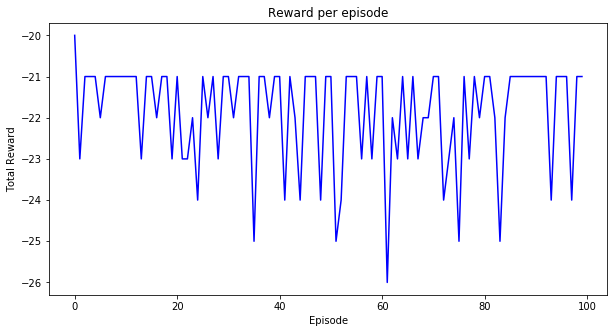

In [23]:
action_space = [0, 1, 2, 3, 4]  # up, right, down, left
agent = Random(action_space=action_space)
grid_size = 5
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size-2) for x in range(grid_size-2)]
max_num_tr = 100
render_flag = True
render_trial = 10000
max_steps_per_trial = 20
reward_per_episode_random =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  render_flag=render_flag, render_trial=render_trial,
                  max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_random)

### SARSA Agent

In [24]:
class SARSAAgent:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))
    # INSTRUCTION 6: return the agent's action.
    def get_action(self, state):
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:                                # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 7: learn from experience
    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state[0], state[1], action]
        next_action = self.get_action(next_state)
        next_max = self.q_table[next_state[0], next_state[1], next_action]
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value
    def get_q_table(self):
        return self.q_table

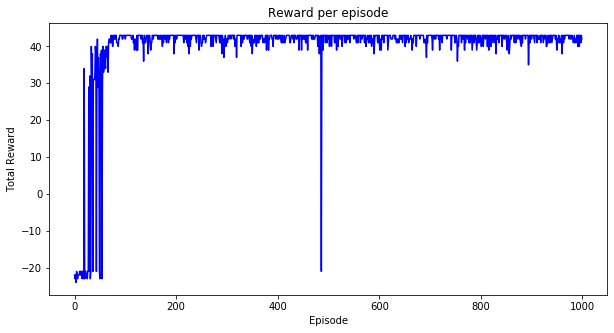

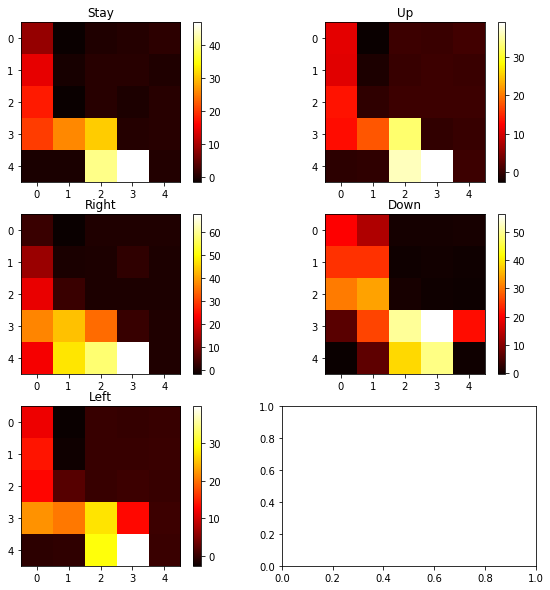

In [25]:
state_space = (grid_size, grid_size)
epsilon = 0.1
agent = SARSAAgent(action_space=action_space, state_space=state_space, epsilon=epsilon)
grid_size = 5
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size-3) for x in range(grid_size-2)]
max_num_tr = 1000
render_flag = True
render_trial = 10000
max_steps_per_trial = 20
reward_per_episode_sarsa =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  render_flag=render_flag, render_trial=render_trial,
                  max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_sarsa)
plot_q_table(agent, action_space)

### Q-Learning Agent

In [26]:
class QLearningAgent:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))
    # INSTRUCTION 8: return the agent's action.
    def get_action(self, state):
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:                                # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 9: learn from experience
    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value
    def get_q_table(self):
        return self.q_table

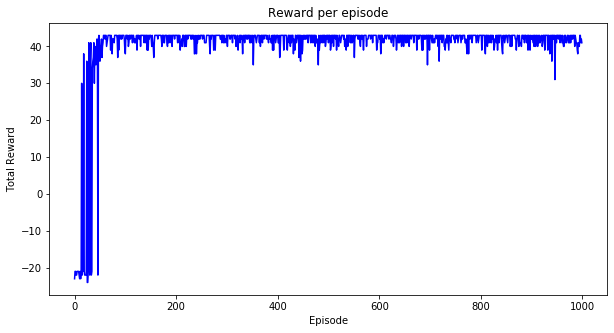

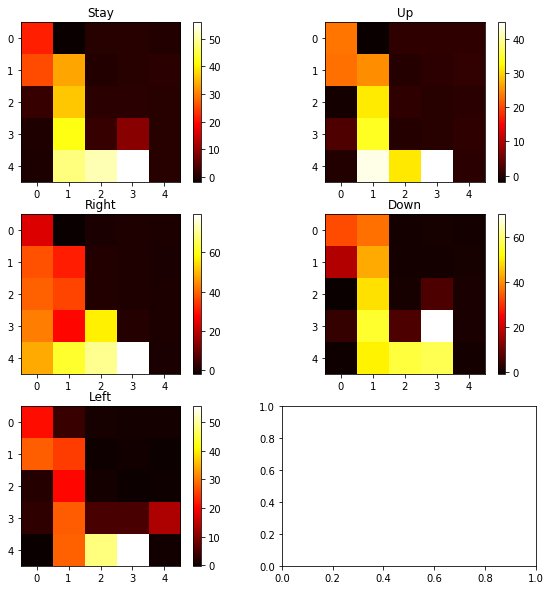

In [27]:
state_space = (grid_size, grid_size)
epsilon = 0.1
agent = QLearningAgent(action_space=action_space, state_space=state_space, epsilon=epsilon)
grid_size = 5
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size-3) for x in range(grid_size-2)]
max_num_tr = 1000
render_flag = True
render_trial = 10000
max_steps_per_trial = 20
reward_per_episode_ql =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  render_flag=render_flag, render_trial=render_trial,
                  max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_ql)
plot_q_table(agent, action_space)

### Q-Learning Agent with elegibility trace

In [28]:
class QLearningAgent_with_eligibility:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=0.1, lambda_=0.9):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))
        self.eligibility_trace = np.zeros((self.state_space[0], self.state_space[1]))
    # INSTRUCTION 10: return the agent's action.
    def get_action(self, state):
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:  # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 11: learn from experience
    def learn(self, state, action, reward, next_state):
        # Increment eligibility trace for visited state and decay all traces
        self.eligibility_trace *= self.gamma * self.lambda_
        self.eligibility_trace[state[0], state[1]] += 1
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])

        # Compute temporal difference error
        delta = reward + self.gamma * next_max - old_value

        # Update Q-value using eligibility trace
        self.q_table[state[0], state[1], action] += self.alpha * delta * self.eligibility_trace[state[0], state[1]]
    def get_q_table(self):
        return self.q_table


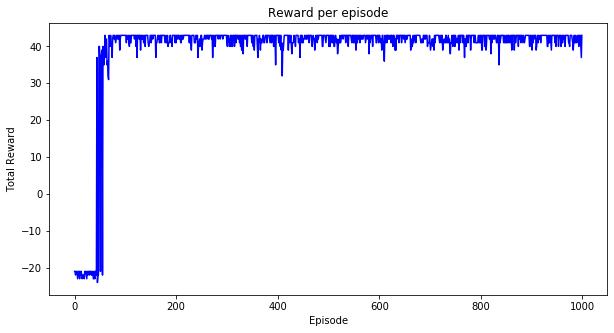

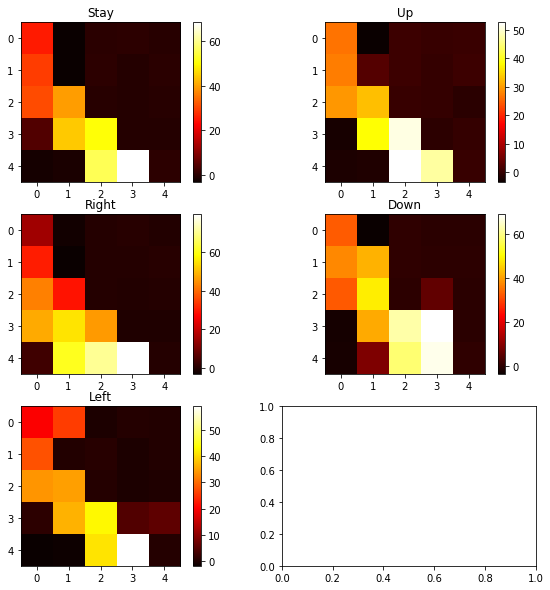

In [29]:
state_space = (grid_size, grid_size)
epsilon = 0.1
alpha = 0.1
gamma = 0.9 
lambda_= 0.9
agent = QLearningAgent_with_eligibility(action_space=action_space, state_space=state_space, epsilon=epsilon,
                                        alpha=alpha, gamma=gamma, lambda_=lambda_)
grid_size = 5
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size-3) for x in range(grid_size-2)]
max_num_tr = 1000
render_flag = True
render_trial = 10000
max_steps_per_trial = 20
reward_per_episode_et =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  render_flag=render_flag, render_trial=render_trial,
                  max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_et)
plot_q_table(agent, action_space)

### Compare learning

In [ ]:
# create figure
f, ax = plt.subplots(figsize=(6, 6))
plot_reward_per_episode(reward_per_episode_random, ax=ax)
plot_reward_per_episode(reward_per_episode_sarsa, ax=ax)
plot_reward_per_episode(reward_per_episode_ql, ax=ax)
plot_reward_per_episode(reward_per_episode_et, ax=ax)
plt.legend(['Random', 'SARSA', 'Q-Learning', 'Q-Learning with Eligibility Trace'])